In [15]:
# %load "quadrature.py"
class Quadrature:
    @staticmethod
    def computeMean(z, Wi, y):
        return np.dot(np.dot(z.T, Wi), y)[0][0]

    @staticmethod
    def computeVariance(gp, z, Wi, A, B, I):
        lsq = gp.kern.lengthscale[0]
        w = gp.kern.variance[0]
        determ = np.linalg.det(2 * np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
        return (w * determ - np.dot(np.dot(z.T, Wi), z))[0][0]

    @staticmethod
    def computeZ(gp, X, i, A, B, b, I):
        x = X[i, :]
        lsq = gp.kern.lengthscale[0]
        w = gp.kern.variance[0]
        determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), np.linalg.inv(A + B)), (x - b).T))
        return w * determ * expon

    @staticmethod
    def integrate(gp, b, v):
        dim = gp.X.shape[1]
        A = gp.kern.lengthscale[0] * np.diag(np.ones(dim))
        B = v * np.diag(np.ones(dim))
        b = b
        I = np.identity(dim)
        X = gp.X
        Y = gp.Y

        K = gp.kern.K(X)
        Ky = K.copy()
        Wi, LW, LWi, W_logdet = GPy.util.linalg.pdinv(Ky)

        z = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            z[i, :] = Quadrature.computeZ(gp, X, i, A, B, b, I)
        return (Quadrature.computeMean(z, Wi, Y), Quadrature.computeVariance(gp, z, Wi, A, B, I))

In [16]:
run "robotworld.py"


ITERATION 0
(19.0, 19.0)


KeyboardInterrupt: 

In [34]:
import scipy.stats
import numpy as np
def f_temp(x):
    return [scipy.stats.norm(3, 1).pdf(x[0])]
def f(x):
    return [scipy.stats.norm(3, 1).pdf(x[0]),scipy.stats.norm(0, 1).pdf(x[1])]
def flambda(a):
    modifier = scipy.stats.norm(0, 1).pdf(a)
    def f(x):
        return [scipy.stats.norm(3, 1).pdf(x[0]) * modifier]
    return f

In [14]:
from sklearn.mixture import GMM
gmm = GMM(1, n_iter=1)
gmm.means_ = np.array([ [0]])
gmm.covars_ = np.array([[1]]) ** 2
gmm.weights_ = np.array([1.0])
gmm.predict_proba

/Library/Python/2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


array([[1.]])

In [10]:
gmm.score(np.array)

TypeError: float() argument must be a string or a number

In [35]:
X = np.random.uniform(-10,10,size=(2,1))
Y = X.copy()
Y = np.apply_along_axis(flambda(0), 1, Y)
gp = GPy.models.GPRegression(X,Y,GPy.kern.src.rbf.RBF(input_dim=1))

In [36]:
Quadrature.integrate(gp,np.array([0.0]),1.0)

(3.101067066016363e-06, 0.40612008441487835)

In [37]:
A = {}
actions = np.linspace(-10,10,30)
Xs = {}
Ys = {}
gps = {}
for i,a in enumerate(actions):
    X = np.random.uniform(-10,10,size=(10,1))
    Y = X.copy()
    Y = np.apply_along_axis(flambda(a), 1, Y)
    Xs[a] = X
    Ys[a] = Y
    gps[a] = GPy.models.GPRegression(X,Y,GPy.kern.src.rbf.RBF(input_dim=1))
    A[a] = Quadrature.integrate(gps[a],np.array([0.0]),10.0)

In [38]:
def extend(rand=False):
    maxa = max(A, key=lambda a:A[a][0]+2*A[a][1])
    if rand:
        maxa = np.random.choice(A.keys())
    print maxa
    X = Xs[maxa]
    X2 = np.random.uniform(-10,10,size=(3,1))
    print X.shape, X2.shape
    Xs[maxa] = np.vstack((X,X2))
    print Xs[maxa].shape
    Y = Xs[maxa].copy()
    Ys[maxa] = np.apply_along_axis(flambda(maxa), 1, Y)
    print Xs[maxa].shape, Ys[maxa].shape
    gps[maxa] = GPy.models.GPRegression(Xs[maxa],Ys[maxa],GPy.kern.src.rbf.RBF(input_dim=1))
    A[maxa] = Quadrature.integrate(gps[maxa],np.array([0.0]),10.0)

In [ ]:
for i in range(400):
    extend(i%5==0)
    x,y,e = [],[],[]
    for a in A:
        x.append(a)
        y.append(A[a][0])
        e.append(A[a][1])
        import matplotlib.pyplot as plt
        plt.clf()
        plt.errorbar(x, y, yerr=e, fmt='o')
        plt.savefig("./imgs/%03d.png" % i)

9.310344827586206
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
3.793103448275863
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
7.241379310344829
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
3.793103448275863
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
10.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-10.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-0.3448275862068968
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
7.241379310344829
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
10.0
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
7.931034482758623
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
1.724137931034484
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
5.862068965517242
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
5.862068965517242
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
-2.413793103448276
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-2.413793103448276
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
0.3448275862068968
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
3.1034482758620694
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
2.4137931034482776
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-1.03

(-6.10817624091876, 0.05524912353256714)


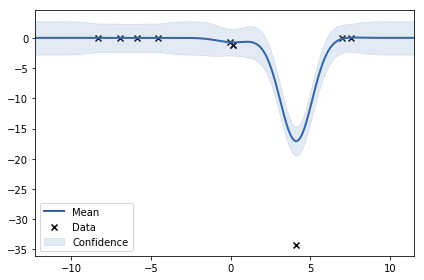

In [33]:
gps[-10.0].plot()
print A[-10.0]